In [2]:
# import dt_apriltags as apriltag
import cv2
import annotation_utils as utils

import numpy as np
from scipy.spatial.transform import Rotation as R

import pyrealsense2 as rs
np.set_printoptions(suppress=True)


import json
import matplotlib.pyplot as plt
# from matplotlib.patches import Polygon

dist = np.zeros(5)
fx = 490
fy = fx
mtx = np.array([[fx, 0., 640], [0., fy, 360], [0., 0., 1.]])

camera_params = [fx, fy, 640, 360]

# dist = np.array([[0.028,  -0.0844,  0.00069588,  0.00022173, -0.12084083]])
corn_coords = 24
#(0, 0,0) 

corners_3D = np.array(
[(0,0,0),
 (-corn_coords,corn_coords, 0),
 (corn_coords, corn_coords,0),
 (corn_coords, -corn_coords,0),
 (-corn_coords, -corn_coords,0)
 ], dtype=float)

keypoints, anchors = utils.get_points_from_CAD()
# anchors[:,2] +=1

Rz_180 = R.from_euler('xyz',[0,0,np.pi])
keypoints = np.hstack((keypoints,np.zeros((keypoints.shape[0],1))))
keypoints = Rz_180.apply(keypoints)
anchors = Rz_180.apply(anchors)

In [3]:
def solve_pnp(obj_points, imagePoints,mtx, dist,reprojectionError ):
    success, rvec, tvec,inliers  = cv2.solvePnPRansac(obj_points, np.array([imagePoints]), mtx, dist,reprojectionError = reprojectionError)
        
    if not success:
        print('not success in PnP')
        return
    return tvec, rvec,inliers


def print_error_rotation(tf_error):
    vec = R.from_matrix(tf_error[:3,:3]).as_rotvec() 
    print("vector in marker", vec/np.linalg.norm(vec))
    print("angles, deg", np.linalg.norm(vec)*57)

def calculate_corrected_kts(tf_error,keypoints):
    keypoints3d_homog = np.hstack((
        keypoints,
        np.ones((keypoints.shape[0],1))))

    keypoints_corrected = (tf_error @ keypoints3d_homog.T).T
    return keypoints_corrected

def get_marker_pose(img_with_marker):
    res = utils.detect_apriltag(img_with_marker, camera_params)

    if res is None:
        return None,None
    corners_2d = res[0].corners
    center_2d = res[0].center
    
    if False:
        img_with_marker = cv2.imread(img_with_marker)
        for p in corners_2d.reshape(-1,2):
            kp = int(p[0]), int(p[1])
            cv2.circle(img_with_marker, kp, 2, (0, 0, 255), -1)
        cv2.imshow("Image", img_with_marker)
        cv2.waitKey(0)
        
    marker_pts_2d = np.vstack((center_2d, corners_2d))

    tvec_m,rvec_m,inliers_m = solve_pnp(corners_3D,corners_2d,mtx, dist, 0.5)
    
    return tvec_m,rvec_m

def get_socket_points(img, points_array, tvec, rvec, 
                      show=True):
    if isinstance(img, str):
        img = cv2.imread(img)
    img_points = None
    img_points, _ = cv2.projectPoints(points_array, rvec, tvec, mtx, dist)
    img_points = img_points.reshape(-1,2)
    copy = img.copy()
    if show:
        for p in img_points.reshape(-1,2):
            kp = int(p[0]), int(p[1])
            cv2.circle(copy, kp, 1, (0, 0, 255), -1)
        cv2.imshow("Image", copy)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    return img_points

def visualize_kpts(img, points_array,color = (0, 0, 255),show_img = False):
    # if isinstance(img, str):
    img = cv2.imread(img)
    
    for p in points_array.reshape(-1,2):
        kp = int(p[0]), int(p[1])
        cv2.circle(img, kp, 1, color, -1)
    
    if show_img:
        cv2.imshow("Image", img)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    return img

In [17]:
# calib_cell
def unpack_vals(kpts_data):
    # kpts_data
    kpts = kpts_data[:14]
    anchors = kpts_data[14:21]
    marker_corners = kpts_data[21:]
    return kpts, anchors,marker_corners

def solve_correction(img_with_marker, anchor_gt_2D):
    res = utils.detect_apriltag(img_with_marker, camera_params)

    corners_2d = res[0].corners
    center_2d = res[0].center

    marker_pts_2d = np.vstack((center_2d, corners_2d))
    tvec_m,rvec_m,inliers_m = solve_pnp(corners_3D,marker_pts_2d,mtx, dist, 0.5)

    tf_m_in_cam = np.eye(4)
    tf_m_in_cam[:3,:3] = R.from_rotvec(rvec_m.flatten()).as_matrix()
    tf_m_in_cam[:3,3] = tvec_m.flatten()

    tvec_gt,rvec_gt,inliers_gt = solve_pnp(anchors,anchor_gt_2D,mtx, dist,1.0)

    tf_s_in_c = np.eye(4)
    tf_s_in_c[:3,:3] = R.from_rotvec(rvec_gt.flatten()).as_matrix()
    tf_s_in_c[:3,3] = tvec_gt.flatten()
    # tf_err_in_m = np.linalg.inv(tf_m_in_cam) @ tf_s_in_c_corrected
    tf_err_in_m = np.linalg.inv(tf_m_in_cam) @ tf_s_in_c

    return tf_err_in_m

name = "09_calib_comp1/"
# name = "09_calib_easy/"
path_to_json = name + "json/captures_000.json"
calib_data = []
with open(path_to_json, "r") as read_file:
    calib_data = json.load(read_file)

all_kpts = []
all_tfs = []

dist = np.zeros(5)
fx = 640
fy = fx 
mtx = np.array([[fx, 0., 640], [0., fy, 360], [0., 0., 1.]])

camera_params = [fx, fy, 640, 360]

for id in range(10):
    img_path = name +'rgb/' + calib_data['captures'][id]["filename"].split('/')[1]
    res = utils.detect_apriltag(img_path, camera_params)
    tvec_m = res[0].pose_t
    rvec_m = (R.from_matrix(res[0].pose_R) ).as_rotvec()

    try: 
        kpts, anchors_2d,marker_corners = unpack_vals(calib_data['captures'][id]["annotations"][1]['values'][0]['keypoints'])
    except:
        kpts, anchors_2d,marker_corners = unpack_vals(calib_data['captures'][id]["annotations"][0]['values'][0]['keypoints'])

    anchors_2d = [[anch['x'],anch['y']] for anch in anchors_2d]
    tvec_gt,rvec_gt,inliers_gt = solve_pnp(anchors,anchors_2d,mtx, dist,1.0)
    tf_err_in_m = solve_correction(img_path, anchors_2d)

    
    all_tfs.append(tf_err_in_m)

rots = R.from_matrix([tf[:3,:3] for tf in all_tfs])
mean_rot = R.mean(rots).as_rotvec()
mean_t = np.mean([tf[:3,3] for tf in all_tfs],axis = 0)
# rot
print(np.rad2deg(np.linalg.norm(mean_rot)),mean_t)

tf_err_in_m = np.eye(4)
tf_err_in_m[:3,:3] = R.from_rotvec(mean_rot).as_matrix()
tf_err_in_m[:3,3] = mean_t
corr_kpts = calculate_corrected_kts(tf_err_in_m,keypoints)


4.123681116413858 [ 2.80026727 -3.18136137  1.06977683]


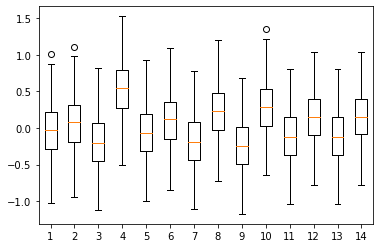

In [31]:
name = "data_complex_marker/"
# name = "09_data_complex/"
# name = "09_data_easy/"

projected_data_name = "our_method_data.json"
original_data = "ground_truth.json"
orig_data = {}
proj_data = {}
N = 8
pack_value = 150    
corr_kpts = np.array(calculate_corrected_kts(tf_err_in_m,keypoints),dtype=float)[:,:-1]
errors = np.zeros((N*pack_value, 14,2))

for i in range(N):
    path_to_json = name + "json/captures_00" + str(i)+ ".json"
    data = []
    with open(path_to_json, "r") as read_file:
        data = json.load(read_file)

    captures = len(data['captures']) #10 
    for id in range(captures):
        img_with_marker = name + 'rgb/' + data['captures'][id]["filename"].split('/')[1]

        res = utils.detect_apriltag(img_with_marker, camera_params)
        tvec_m = res[0].pose_t
        rvec_m = (R.from_matrix(res[0].pose_R) ).as_rotvec()
        
        try: 
            kpts, anchors_2d,marker_corners = unpack_vals(data['captures'][id]["annotations"][1]['values'][0]['keypoints'])
        except:
            kpts, anchors_2d,marker_corners = unpack_vals(data['captures'][id]["annotations"][0]['values'][0]['keypoints'])
            
        kpts = [[anch['x'],anch['y']] for anch in kpts]
        kpts_corrected = get_socket_points(img_with_marker,corr_kpts, tvec_m,rvec_m,show = False)
        
        errors[i* len((data['captures'])) + id] = kpts_corrected - kpts
        proj_data[data['captures'][id]["filename"].split('/')[1]] = kpts_corrected.tolist()
        orig_data[data['captures'][id]["filename"].split('/')[1]] = kpts
        

with open(projected_data_name, "w") as write_file:
    json.dump(proj_data, write_file)

with open(original_data, "w") as write_file:
    json.dump(orig_data, write_file)

fig, ax = plt.subplots()
ax.boxplot(errors[:,:,0])

plt.show()

In [ ]:
# for id,val in orig_data.items():
#     print(np.array(orig_data[id]) - np.array(proj_data[id]))
    # raise 


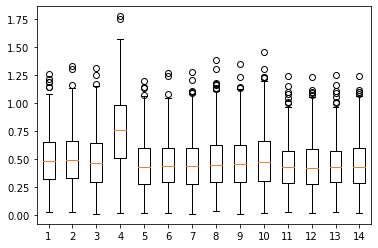

In [29]:
fig, ax = plt.subplots()
# ax.boxplot(errors[:,:,1])
ax.boxplot(np.linalg.norm(errors,axis = 2))

plt.show()

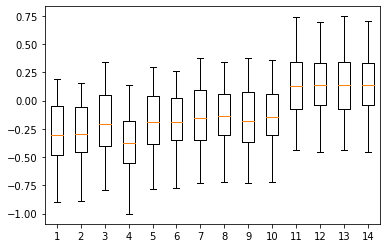

In [118]:
fig, ax = plt.subplots()
ax.boxplot(errors[:,:,1])

plt.show()

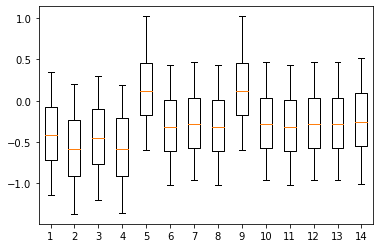

In [101]:
tricky_errors = errors[:,:,0].copy()
even = tricky_errors[:,::2]
uneven = tricky_errors[:,1::2]
for i in range(even.shape[1]):
    tricky_errors[:,i] = uneven[:,i]

for i in range(uneven.shape[1]):
    tricky_errors[:,i+even.shape[1] ] = even[:,i]

fig, ax = plt.subplots()
ax.boxplot(tricky_errors[:,:])
plt.show()


In [89]:
# total debug node
# name= "total_debug/"
name= "debug_data_06/with_cover/"
path_to_json = name+ "json/captures_000.json"
data = []
with open(path_to_json, "r") as read_file:
    data = json.load(read_file)

# errors = np.zeros((len(data['captures']), 14,2))

errors_debug_data_06 = np.zeros((len(data['captures']), 14,2))
# debug_data_06/with_cover
for id in range(len(data['captures'])):
    img_with_marker = name+ 'rgb/' + data['captures'][id]["filename"].split('/')[1]

    corners_2D_data = data['captures'][id]["annotations"][0]['values'][0]['keypoints'][-4:] 
    corners_2D_data = np.array([[anch['x'],anch['y']] for anch in corners_2D_data])

    res = utils.detect_apriltag(img_with_marker, camera_params)
    tvec_m = res[0].pose_t
    rvec_m = (R.from_matrix(res[0].pose_R) ).as_rotvec()

    points_array = data['captures'][id]["annotations"][0]['values'][0]['keypoints'][:-11] 
    points_array = np.array([[anch['x'],anch['y']] for anch in points_array])

    kpts_was = get_socket_points(img_with_marker,keypoints, tvec_m,rvec_m,show = False)

    kpts_gt = data['captures'][id]["annotations"][0]['values'][0]['keypoints'][:-7] 
    kpts_gt = [[anch['x'],anch['y']] for anch in kpts_gt]
    errors_debug_data_06[id] = kpts_was - points_array

fig, ax = plt.subplots()
ax.boxplot(errors_debug_data_06[:,:,0])

plt.show()

[ 0  1  2  3  4  5  6  7  8  9 10]
[ 0  2  4  6  8 10]
[1 3 5 7 9]


In [72]:
# corners_3D
import importlib
# importlib.reload(utils)

path_to_json = "late_08/json/captures_000.json"
with open(path_to_json, "r") as read_file:
    data = json.load(read_file)
N = 150
total3d = [keypoints for i in range(N)]
# np.repeat(corners_3D, 4, axis = 0).reshape()
corners2d = []
for id in range(N):
    try: 
        kpts, anchors_2d,marker_corners = unpack_vals(data['captures'][id]["annotations"][1]['values'][0]['keypoints'])
    except:
        kpts, anchors_2d,marker_corners = unpack_vals(data['captures'][id]["annotations"][0]['values'][0]['keypoints'])
    points_array = np.array([[anch['x'],anch['y']] for anch in kpts])
    
    img_path = 'late_08/rgb/' + data['captures'][id]["filename"].split('/')[1]
    img = visualize_kpts(img_path, points_array,color = (255, 0, 0),show_img = False)
   # tvec_gt,rvec_gt,inliers_gt = solve_pnp(anchors,anchors_2d,mtx, dist,1.0)
    corners2d.append(points_array)

total3d = np.array(total3d,dtype = np.float32)
corners2d = np.array(corners2d,dtype = np.float32)
print(total3d.shape)
print(corners2d.shape)
mtx = np.eye(3)
mtx[0,0] = 650
mtx[1,1] = 650
mtx[0,2] = 640
mtx[1,2] = 360

ret, mtx, dist = cv2.initCameraMatrix2D (total3d,corners2d,(1280,720),1.77)
print(ret,mtx, dist)
# calibrateCamera 
# initCameraMatrix2D


(150, 14, 3)
(150, 14, 2)
[820.01875685   0.         639.5       ] [  0.         463.28743325 359.5       ] [0. 0. 1.]


In [ ]:
def solve_correction(img_with_marker, anchor_gt_2D):
    def apply_correction():
        result = tf_s_in_c.copy()
        z_from = tf_s_in_c[:3,2]
        z_to = tf_m_in_cam[:3,2]
        angle = np.arccos(z_from@z_to)
        rot_ax = np.cross(z_from,z_to)

        rot_vec = rot_ax /np.linalg.norm(rot_ax) * angle
        rot_mtx = R.from_rotvec(rot_vec).as_matrix()
        # print(rot_mtx @ z_from -z_to )

        result[:3,:3]  = rot_mtx @ tf_s_in_c[:3,:3]
        result[3,3]  = tf_m_in_cam[3,3]
        # correction for OZ
        # d_cam = - (tf_s_in_c[:3,3] - tf_m_in_cam[:3,3])
        
        # d_cam = - (tf_s_in_c[:3,3] - tf_m_in_cam[:3,3])
        # z_proj = (d_cam) @ z_to
        # corr_z = np.eye(4)
        # corr_z[2,3] = z_proj
        # return result @ corr_z
        return result 

    res = utils.detect_apriltag(img_with_marker, camera_params)

    corners_2d = res[0].corners
    center_2d = res[0].center

    marker_pts_2d = np.vstack((center_2d, corners_2d))
    tvec_m,rvec_m,inliers_m = solve_pnp(corners_3D,marker_pts_2d,mtx, dist, 0.5)

    print("from socket")
    print(tvec_m,R.from_rotvec(rvec_m.flatten()).as_matrix())
    
    print("from detection")
    print(res[0].pose_t,res[0].pose_R)
    

    tvec_m = res[0].pose_t
    # * R.from_euler('xyz',[0,0,np.pi])
    rvec_m = (R.from_matrix(res[0].pose_R)).as_rotvec()
    # print("inliers_m\n",inliers_m.T)

    tf_m_in_cam = np.eye(4)
    tf_m_in_cam[:3,:3] = R.from_rotvec(rvec_m.flatten()).as_matrix()
    tf_m_in_cam[:3,3] = tvec_m.flatten()

    tvec_gt,rvec_gt,inliers_gt = solve_pnp(anchors,anchor_gt_2D,mtx, dist,1.0)
    # print(R.from_rotvec(rvec_gt.flatten()).as_matrix())
    # print("inliers_gt\n",inliers_gt.T)

    tf_s_in_c = np.eye(4)
    tf_s_in_c[:3,:3] = R.from_rotvec(rvec_gt.flatten()).as_matrix()
    tf_s_in_c[:3,3] = tvec_gt.flatten()
    tf_s_in_c_corrected = apply_correction()
    # tf_err_in_m = np.linalg.inv(tf_m_in_cam) @ tf_s_in_c_corrected
    tf_err_in_m = np.linalg.inv(tf_m_in_cam) @ tf_s_in_c_corrected
    tf_err_in_m[:3,3] *=-1
    return tf_err_in_m

In [ ]:
anchors_list = [
    [[699, 421],[682, 397],[717, 397],[665, 421],[735, 421],[682, 451],[717, 451]],
    [[608, 418],[594, 398],[623, 398],[ 578, 418],[368, 418],[593, 444],[623, 444]],
    [[610, 417],[597, 399],[623, 399],[584, 417],[636, 417],[597,439],[623, 439]]
]
pics_list = [335, 559, 784]

kpts_list = []
for i in range(3):
    img_with_marker_name = "data_for_corr_new/" + str(pics_list[i]) + ' (2).jpg'
    img_without_marker_name = "data_for_corr_new/" + str(pics_list[i]) + '.jpg'
    anchor_gt_2D = np.array(anchors_list[i], dtype = float)
    img_with_marker = cv2.imread(img_with_marker_name)
    img_without_marker = cv2.imread(img_without_marker_name)
    
    tf_err_in_m = solve_correction(img_with_marker, anchor_gt_2D)
    corr_kpts = calculate_corrected_kts(tf_err_in_m,keypoints)
    kpts_list.append(corr_kpts)

kpts_list = np.array(kpts_list)
kpts_list.var
corr_kpts_mean = np.mean(kpts_list, axis = 0, dtype=np.float32)
corr_kpts_new = np.array(corr_kpts_mean[:,:3],dtype=float)
for i in range(3):
    img_with_marker_name = "data_for_corr_new/" + str(pics_list[i]) + ' (2).jpg'
    img_without_marker_name = "data_for_corr_new/" + str(pics_list[i]) + '.jpg'
    img_with_marker = cv2.imread(img_with_marker_name)

    tvec_m,rvec_m = get_marker_pose(img_with_marker)
    
    img_without_marker = cv2.imread(img_without_marker_name)
    get_socket_points(img_without_marker,corr_kpts_new , tvec_m,rvec_m)

In [ ]:
# averaging the corrections

anchors_list = [
    [[699, 421],[682, 397],[717, 397],[665, 421],[735, 421],[682, 451],[717, 451]],
    [[608, 418],[594, 398],[623, 398],[ 578, 418],[368, 418],[593, 444],[623, 444]],
    [[610, 417],[597, 399],[623, 399],[584, 417],[636, 417],[597,439],[623, 439]]
]
pics_list = [335, 559, 784]

kpts_list = []
for i in range(3):
    img_with_marker_name = "data_for_corr_new/" + str(pics_list[i]) + ' (2).jpg'
    img_without_marker_name = "data_for_corr_new/" + str(pics_list[i]) + '.jpg'
    anchor_gt_2D = np.array(anchors_list[i], dtype = float)
    img_with_marker = cv2.imread(img_with_marker_name)
    img_without_marker = cv2.imread(img_without_marker_name)
    
    tf_err_in_m = solve_correction(img_with_marker, anchor_gt_2D)
    corr_kpts = calculate_corrected_kts(tf_err_in_m,keypoints)
    kpts_list.append(corr_kpts)

kpts_list = np.array(kpts_list)
kpts_list.var
corr_kpts_mean = np.mean(kpts_list, axis = 0, dtype=np.float32)
corr_kpts_new = np.array(corr_kpts_mean[:,:3],dtype=float)
for i in range(3):
    img_with_marker_name = "data_for_corr_new/" + str(pics_list[i]) + ' (2).jpg'
    img_without_marker_name = "data_for_corr_new/" + str(pics_list[i]) + '.jpg'
    img_with_marker = cv2.imread(img_with_marker_name)

    tvec_m,rvec_m = get_marker_pose(img_with_marker)
    
    img_without_marker = cv2.imread(img_without_marker_name)
    get_socket_points(img_without_marker,corr_kpts_new , tvec_m,rvec_m)

In [ ]:
Tc = np.eye(4)
Tc[:3,:3] = R.from_euler('xyz', [30,10,-10], degrees = True).as_matrix()
Tc[:3,3] = np.array([100,30,50])

T = np.eye(4)
T[:3,:3] = R.from_euler('xyz', [-30,54,-5], degrees = True).as_matrix()
T[:3,3] = np.array([18,-33,10])
point = np.zeros(4)
point[-1] = 1
point = T @ point
print(point)
prox = Tc @ point.T @ np.linalg.inv(Tc)
# prox /= prox[-1]
print(prox)


In [ ]:
data = {}
photos_to_ignore = [i for i in range(18,27)]
processed_data = 0
for i in range(10):
    if i in photos_to_ignore:
        continue
    img_with_marker_name = "close_photos_marker/" + str(i) + '.jpg'
    img_without_marker_name = "close_photos_no_marker_normal/" + str(i) + '.jpg'
    img_with_marker = cv2.imread(img_with_marker_name)

    tvec_m,rvec_m = get_marker_pose(img_with_marker)
    print(tvec_m,rvec_m)
    if tvec_m is None:
        continue
    img_without_marker = cv2.imread(img_without_marker_name)
    data[i] = get_socket_points(img_without_marker,corr_kpts_new , tvec_m,rvec_m, show=False).tolist()

    processed_data += 1
    
with open("ground_truth_keypoints.json", "w") as write_file:
    json.dump(data, write_file)

In [ ]:
import json
data = {}
# "10" +

for i in range(100):
    img_with_marker_name = "100_photos/" + "4_" + str(i)+'.png'
    # print(img_with_marker_name)
    # img_without_marker_name = "data_for_corr_new/" + str(pics_list[i]) + '.jpg'
    img_with_marker = cv2.imread(img_with_marker_name)
    img_with_marker = cv2.rotate(img_with_marker, cv2.ROTATE_90_COUNTERCLOCKWISE)
    tvec_m,rvec_m = get_marker_pose(img_with_marker)
    if tvec_m is None:
        raise

    # img_without_marker = cv2.imread(img_without_marker_name)
    data[i] = get_socket_points(img_with_marker,corr_kpts_new , tvec_m,rvec_m, show=False).tolist()

    
with open("4.json", "w") as write_file:
    json.dump(data, write_file)


In [ ]:
# print(data.items())

In [ ]:
keypoints_new = (tf_s_in_c @ anchor_kpts.T).T
print(keypoints_new)
print(keypoints.shape)
keypoints = np.hstack((
    keypoints,
    np.zeros((keypoints.shape[0],1)),
    np.ones((keypoints.shape[0],1))))


keypoints_corrected = (tf_err_in_m @ keypoints.T).T

print(keypoints_corrected)

In [ ]:
# old data for correction
anchors_list = [
    [[654, 358], [630,325],[680,324],[606,359],[703,358],[631,399],[679,399]],
    [[652, 355],[630, 326],[673, 325],[609,356],[695, 356],[631, 393],[674, 393]],
    [[648, 355],[630, 329],[670,328],[611, 355],[688, 355],[630,389],[669, 389]],
    [[648,355],[630,331],[666, 331],[613, 355],[684,355],[630,386],[666, 386]],
    [[647, 355],[630,332],[663, 332],[614, 355],[679,355],[630,383],[663,383]]
]
pics_list = [44, 108, 172,236,300]
img_with_marker_name = "data_for_correction/" + str(pics_list[i]) + ' (2).jpg'
img_without_marker_name = "data_for_correction/" + str(pics_list[i]) + '.jpg'